# Relazione di Web Mining

1. Introduzione
    1. [Ambiente di Sviluppo](###-1.1-Ambiente-di-Sviluppo)
    2. [Introdizuone alla nostra Rete](###-1.2-Introduzione-alla-nostra-Rete)
        - Proprietà della Rete
        - Statistiche di Rete


## 1. Introduzione
### 1.1 Ambiente di Sviluppo
Nel nostro caso abbiamo deciso di utilizzare come ambiente di sviluppo i Github Codespaces offerti dall'Università, utilizzando delle impostazioni di configurazione manuale per impostare R, linguaggio di programmazione utilizzato durante il corso, e Jupiter, un ambiente di sviluppo interattivo con il quale è stata scritta questa relazione.\
Per ottenere un ambiente di sviluppo identico al nostro basta creare una repository di Github, inserire la cartella .devcontainer al suo interno e poi creare un codespace sulla repository.


### 1.2 Introduzione alla nostra Rete
La [rete da noi scelta](http://vlado.fmf.uni-lj.si/pub/networks/data/esna/metalWT.htm) descrive il commercio di oggetti in metallo tra 80 paesi nel mondo nel 1994. \
Un collegamento $Y_{ij}$ rappresenta le importazioni da un paese ad un altro riguardanti oggetti in metallo, in parole semplici possiamo vedere un collegamento $Y_{ij}$ come la richiesta di oggetti in metallo da parte del nodo $i$ al nodo $j$. 
#### Proprietà della Rete
La nostra rete contiene 80 nodi (paesi) e 1000 collegamenti (scambi commerciali) e ogni nodo contiene i seguenti attributi:
- Il loro Continente di appartenenza
- La loro Posizione rispetto alla Struttura del Sistema Mondiale nel 1994
- Il loro PIL diviso per il numero di cittadini all'interno di tale paese nel 1995
---
Dal sito è possibile scaricare soltanto il file 'world_trade.paj' che contiene i nomi delle nazioni, la edge list corrispondente alla nostra rete e gli attributi nodali.
Da questo file abbiamo ricavato il file 'edge_list.txt', contenente la lista degli archi della nostra rete, e 'nodes_attr.txt' contenente i nomi e i relativi attributi nodali dei nodi.
Dopodiché tramite l'utilizzo della libreria igraph abbiamo impostato la nostra rete in R:



In [2]:
# Rimozione dati dalla sessione di R in caso fossero presenti
rm(list = ls())

# Abilita l'utilizzo della libreria 'igraph'
library(igraph)

# Importazione della edge list 
edgeList <- read.table("edge_list.txt", sep = "", head = FALSE)

# Importazione degli attributi dei nodi
attr <- read.table("nodes_attr.txt", sep = "", head = TRUE)

# Creazione del grafo e assegnazione degli attributi ai nodi
g <- graph_from_edgelist(as.matrix(edgeList), directed = TRUE)
V(g)$continent <- attr$Continents
V(g)$gdp <- attr$GDP
V(g)$world_partition <- attr$World_Partitions
V(g)$xCoordinate <- attr$xCoordinates
V(g)$yCoordinate <- attr$yCoordinates
V(g)$name <- attr$Names

print(g)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




IGRAPH f8ed693 DN-- 80 1000 -- 
+ attr: continent (v/n), gdp (v/n), world_partition (v/n), xCoordinate
| (v/n), yCoordinate (v/n), name (v/c)
+ edges from f8ed693 (vertex names):
 [1] United States->French Guiana France       ->French Guiana
 [3] Germany      ->French Guiana Italy        ->French Guiana
 [5] United States->Guadeloupe    Belgium/Lux. ->Guadeloupe   
 [7] France       ->Guadeloupe    Germany      ->Guadeloupe   
 [9] Italy        ->Guadeloupe    United States->Norway       
[11] Japan        ->Norway        China        ->Norway       
[13] Belgium/Lux. ->Norway        Denmark      ->Norway       
+ ... omitted several edges


#### Statistiche di Rete
Dopodichè tramite l'utilizzo dei seguenti comandi abbiamo calcolato le nostre statistiche di Rete.

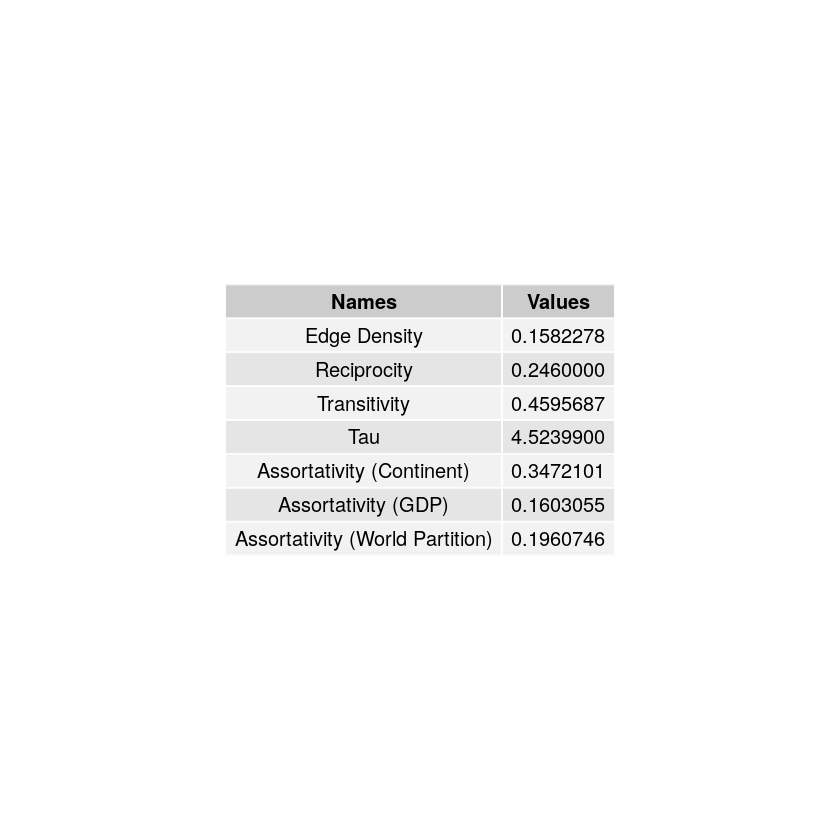

In [39]:
# Creazione della matrice di adiacenza relativa al grafo g
Y <- as_adjacency_matrix(g)
diag(Y) <- NA

# Calcolo delle statistiche di rete
rho <- edge_density(g)
reciprocity <- reciprocity(g)
transitivity <- transitivity(g)
odd_rho <- rho / (1 - rho)
odd_transitivity <- transitivity / (1 - transitivity)
tau <- odd_transitivity / odd_rho
assortativity_continent <- assortativity(g, V(g)$continent, directed = TRUE)
assortativity_gdp <- assortativity(g, V(g)$gdp, directed = TRUE)
assortativity_worldpartition <- assortativity(g, V(g)$world_partition, directed = TRUE)

# Create a table with names and values
library(gridExtra)
library(grid)
table <- data.frame(
	Names = c("Edge Density", "Reciprocity", "Transitivity", "Tau", "Assortativity (Continent)", "Assortativity (GDP)", "Assortativity (World Partition)"),
	Values = c(rho, reciprocity, transitivity, tau, assortativity_continent, assortativity_gdp, assortativity_worldpartition)
)

grid.table(table, rows = NULL)

Dall'immagine sopra possiamo estrapolare delle informazioni riguardo alla nostra rete, cioè: 
- Circa 1/4 delle connessioni è reciprocata.
- La transitività nella nostra rete è molto alta, circa 4 volte di più rispetto al caso random.
- Il coefficiente di assortatività è positivo per tutti e 3 gli attributi nodali.
Con queste informazioni possiamo già dire che la nostra rete ha un'alta tendenza a formare dei cluster (o gruppi).

#### Statistiche Nodali
Per quanto riguarda le Statistiche Nodali, cioè:
- In Degree Centrality
- Out Degree Centrality
- In Closeness Centrality
- Out Closeness Centrality
- Betweenness Centrality
- Eigen-Vector Centrality
abbiamo ottenuto i seguenti risultati:

##### In Degree Centrality
Per quanto riguarda la In Degree Centrality abbiamo ottenuto i seguenti risultati

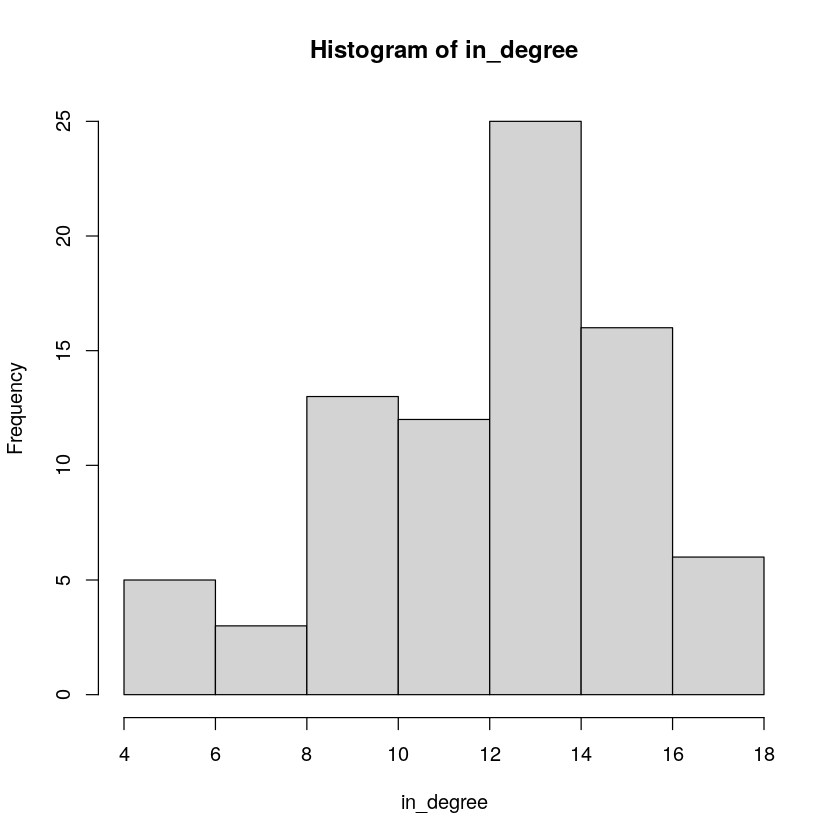

In [40]:
# Calcolo della InDegree Centrality
in_degree <- degree(g, mode = "in")
# Istogramma dell'In Degree Centrality
hist(in_degree)

In [35]:
# Stampo il Summary dell'In Degree Centrality
summary(in_degree)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    4.0    10.0    13.0    12.5    15.0    18.0 

In [33]:
# Stampo le 5 Nazioni con In Degree più Alto
matrix(c(V(g)$name[order(in_degree, decreasing = TRUE)[1:5]], in_degree[order(in_degree, decreasing = TRUE)[1:5]]), 
    nrow = 2, ncol = 5, byrow = TRUE,
    dimnames = list(c("Nazioni", "In Degree Value"), c(1:5)))

,1,2,3,4,5
Nazioni,Australia,Germany,Southern Africa,Chile,Jordan
In Degree Value,18,18,18,17,17


In [38]:
# Stampo la centralità della Rete rispetto all'In Degree
centr_degree(g, loops = FALSE, mode = "in")$centralization

[1] 0.07050152

Dai dati sopra osservati possiamo affermare che la nostra rete è una rete molto ben distribuita per quanto riguarda la Statistica Nodale In Degree, questo significa che LO SCOPRIREMO DOMANI HIHIHIHIHI